# ASTR 596: FDS - The Midterm

### Dun, dun dun. 
#### (suspenseful music here)

## Start with the Cepheid data you have already seen in lecture 03 and 04.

## There are measurements of several Cepheid variable stars in each of 9 nearby galaxies.

## Begin by reading this code and familiarizing yourself with what attributes and functions are available to you. In particular, it will help to read comments at the top of the data file.

In [2]:
exec(open('cepheids.py').read())
ceph = Cepheids('../../data/03/R11ceph.dat')
hosts = ceph.list_hosts()

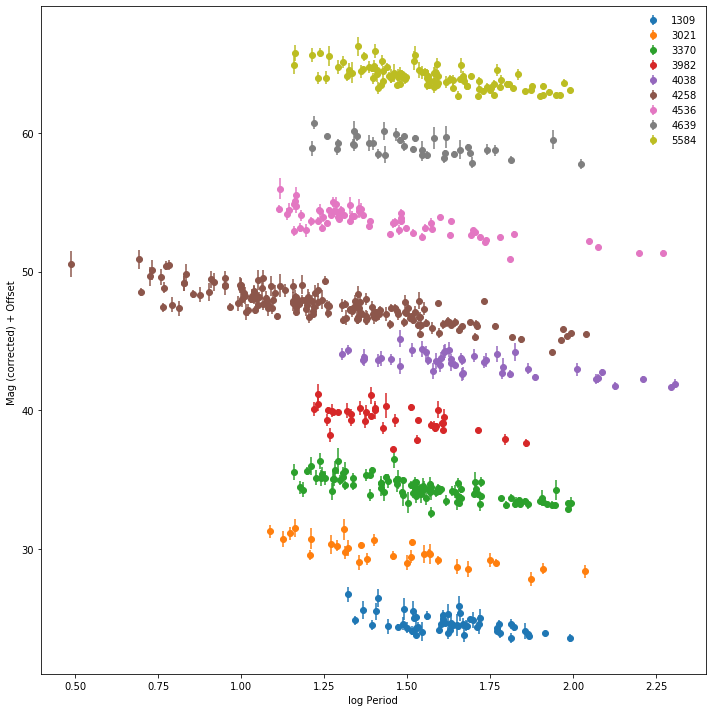

In [3]:
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

for i, ID in enumerate(hosts):
    ceph.select(ID)
    mobs = ceph.mobs
    logP = ceph.logP
    sigma_obs = ceph.sigma
    ax.errorbar(logP, mobs+(5*i), yerr=sigma_obs, linestyle='None', marker='o', label=ID)
    
ax.legend(frameon=False)
ax.set_xlabel('log Period')
ax.set_ylabel('Mag (corrected) + Offset ')
fig.tight_layout()

# Q1.

## This data was taken from [Riess et al., 2011](https://arxiv.org/abs/1103.2976)

## The global model for the magnitudes of these Cepheids is given in Equation 1. You may ignore the effect of metalicity

## Some parameters (such as distance modulus) are specific to each galaxy.

## Others are common to all galaxies. 

## Assuming Gaussian magnitude errors and no period error (and you may ignore metallicity entirely), but that Cepheids scatter off the period-luminosity relation because of some Gaussian intrinsic dispersion $\sigma_{\text{int}}$, write down your expression for the likelihood being careful to use the same indices that Riess et. al used.


We can take the negative log likelihood straight from the code given to us.

The generic chi squared formula being:

$$
\chi^2_{i,j} = \sum_{i,j} \left( \frac{m_{obs,i,j} - a_i \log P_{i,j} - b_i}{\sigma_{int}} \right)^2
$$

and plugging in the terms from Riess et al. (while also ignoring the metallicity terms):

$$ 
-\log L_{i,j} = \frac{1}{2}\sum_{i,j} \left( \frac{m_{W,i,j} - b_W \log P_{i,j} - \left[ \left( \mu_{0,i} - \mu{0,4258} \right) + zp_{W,4258} \right ]}{\sigma_{int}} \right)^2
$$

# Q2. 

## Given what you know for each of the parameters in this model, write down physically motivated (i.e. not just top hats on everything) priors, along with your explanation.

## Think particularly about the priors for distances to each galaxy.

Distances have to be positive.

The magnitudes must be somewhat high (faint) because these are stars in other galaxies. From Leavitt's law we know that as period increases Cepheids will become brighter (negative magnitude) so the slope in this graph will be negative.

Starting points for these numbers look like they could be somewhere around -5 < $a_i$ < 0 and 24 < $b_i$ < 35 

# Q3. 

## Implement this likelihood and prior in python and sample the posterior distribution with emcee.

## Construct traceplots for each parameter, as well as corner plots for each pair of parameters.


## If your Markov Chains are reasonable, verify that your model fits are reasonable by reconstructing Fig. 7 of Riess et al. 2011

## Compare the intercept you find for the intercepts $\mu_{0,i} - \mu_{0, 4258}$ vs Table 3 of Riess et al. 2011

100%|███████████████████████████████████████████████| 2000/2000 [00:04<00:00, 462.84it/s]


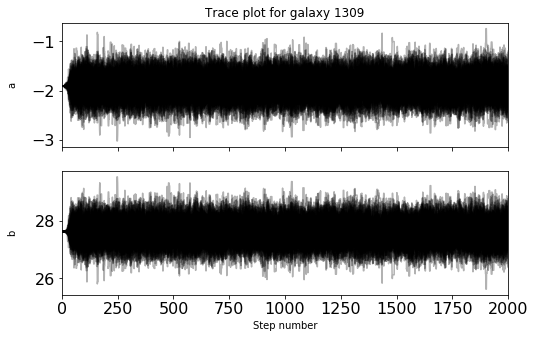

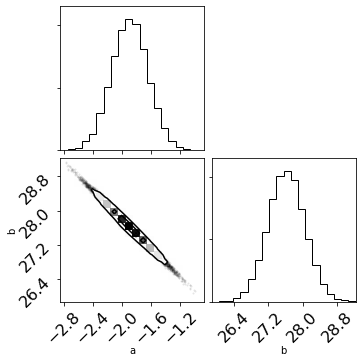

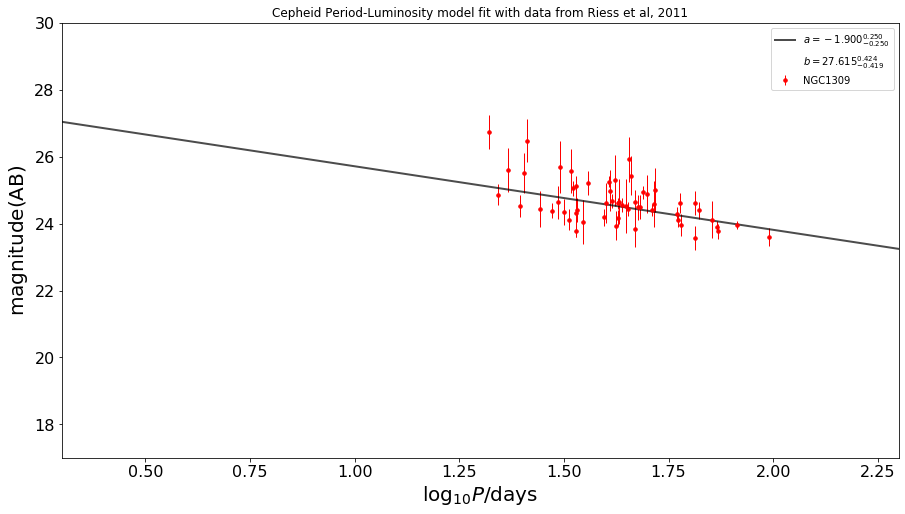

100%|███████████████████████████████████████████████| 2000/2000 [00:04<00:00, 473.45it/s]


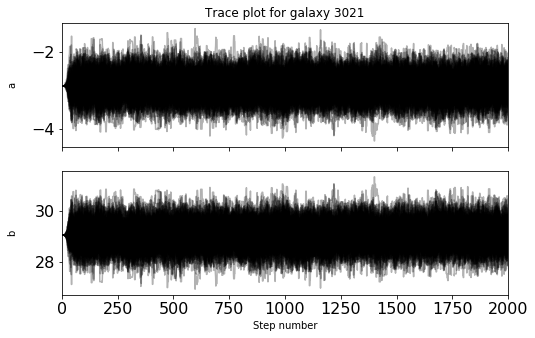

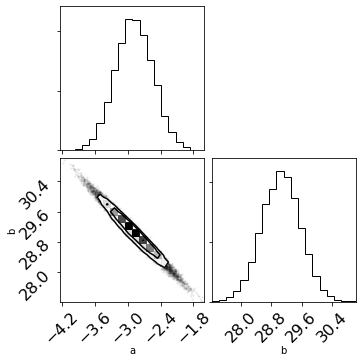

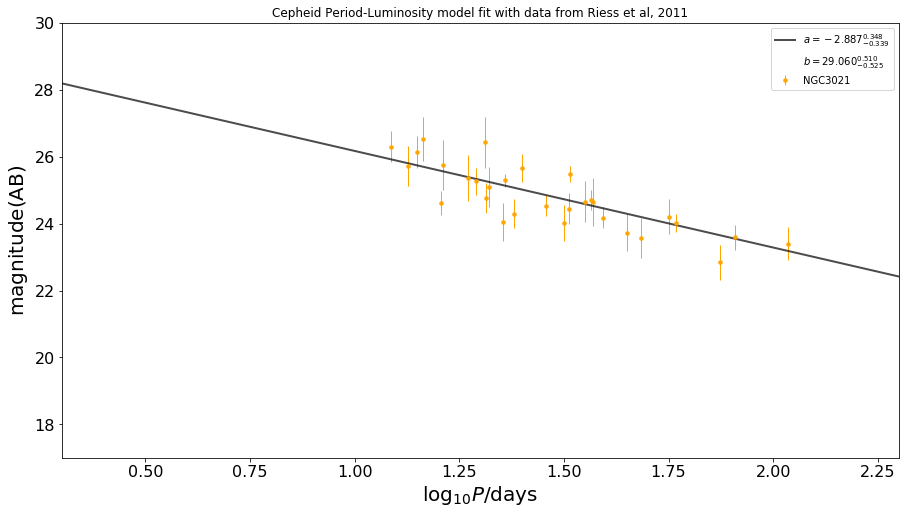

100%|███████████████████████████████████████████████| 2000/2000 [00:04<00:00, 475.00it/s]


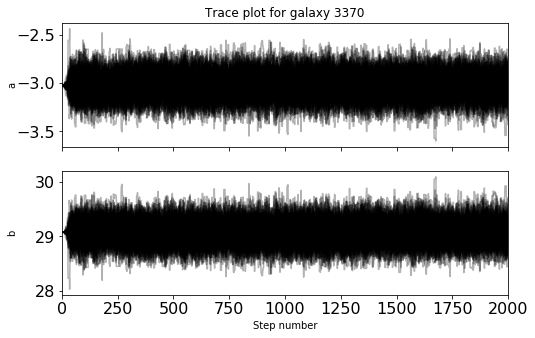

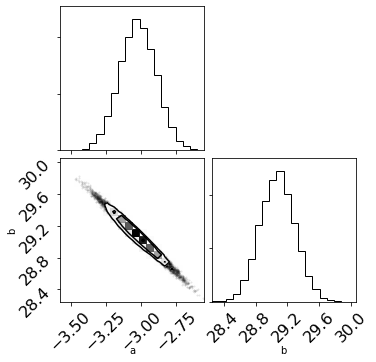

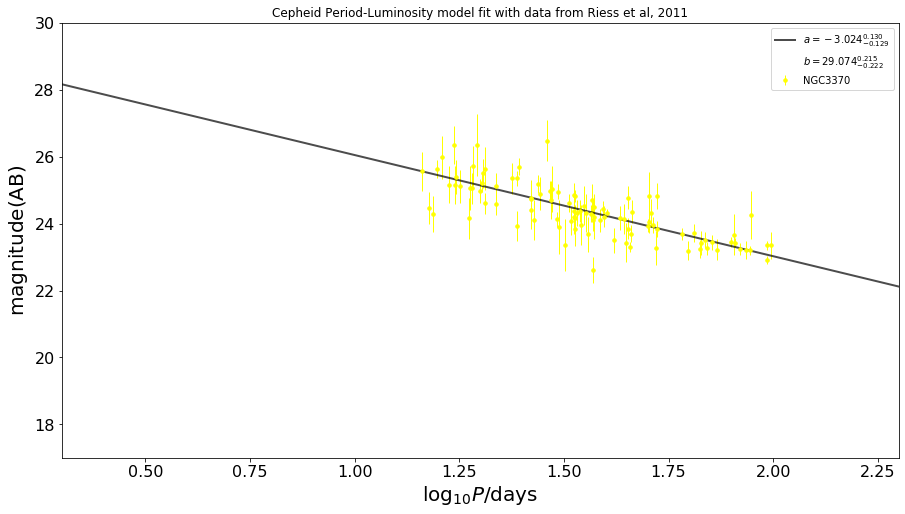

100%|███████████████████████████████████████████████| 2000/2000 [00:04<00:00, 474.87it/s]


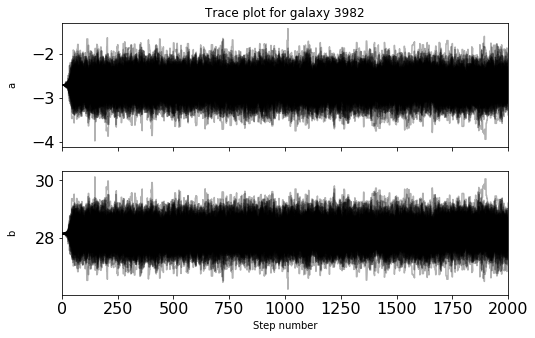

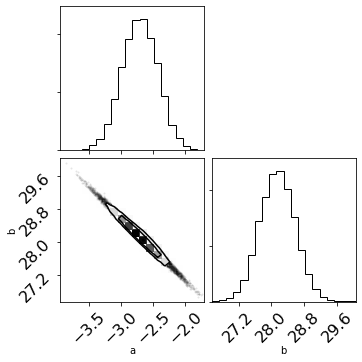

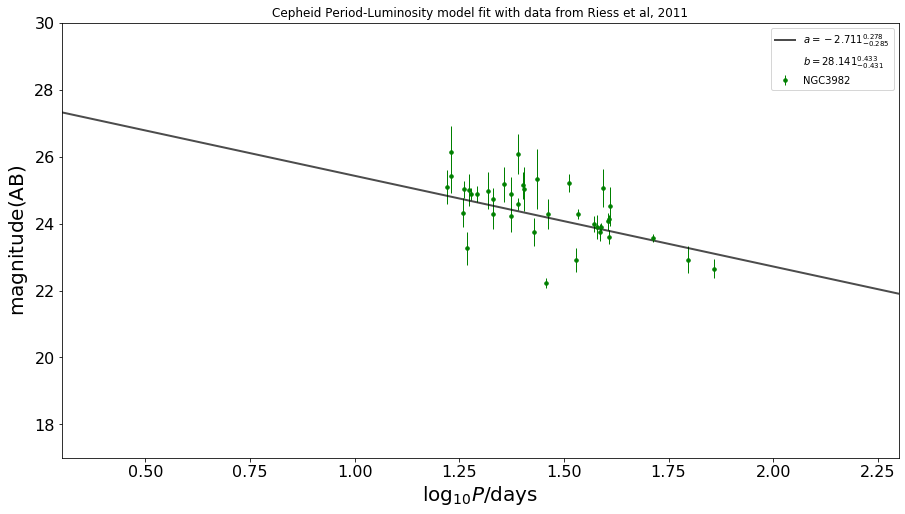

100%|███████████████████████████████████████████████| 2000/2000 [00:04<00:00, 476.37it/s]


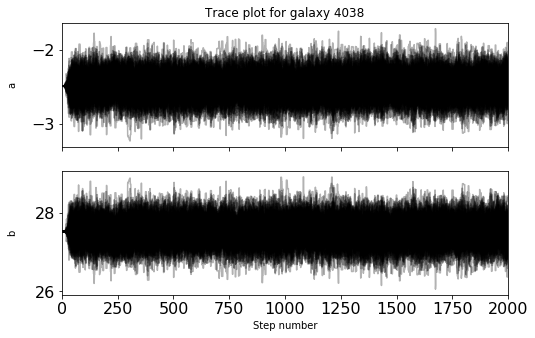

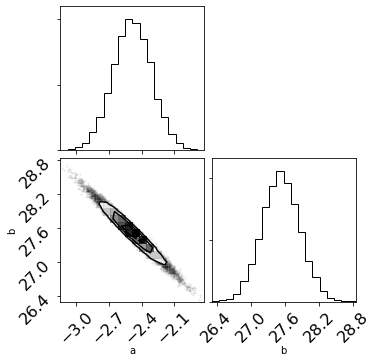

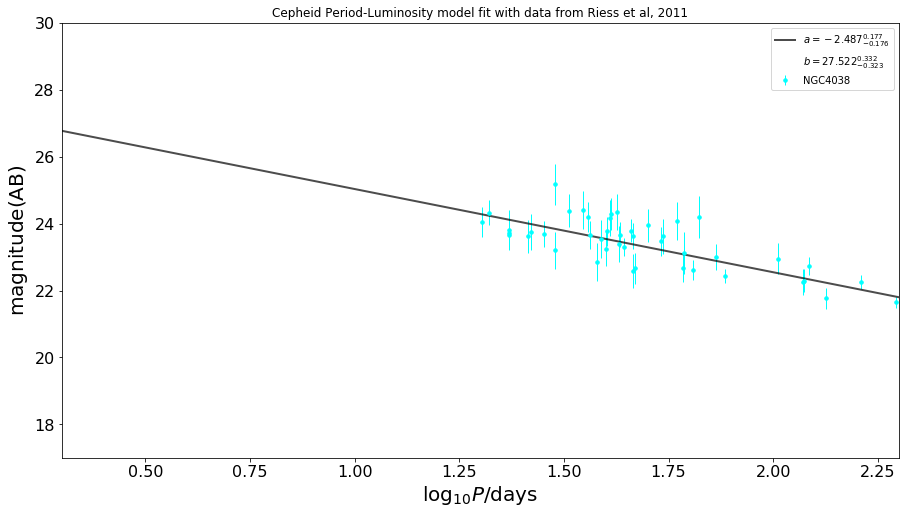

100%|███████████████████████████████████████████████| 2000/2000 [00:04<00:00, 428.93it/s]


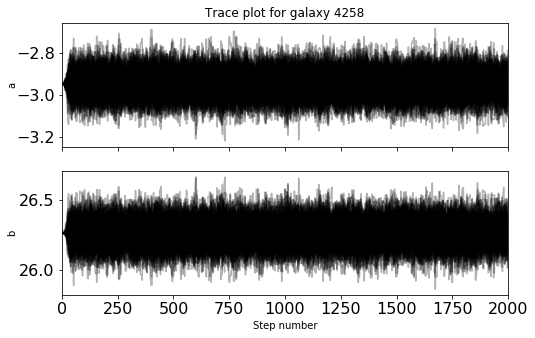

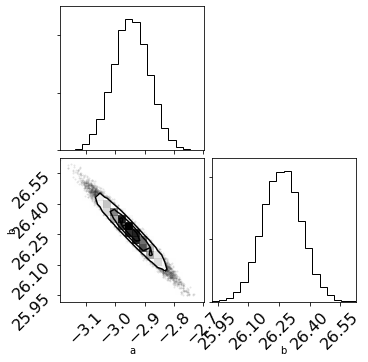

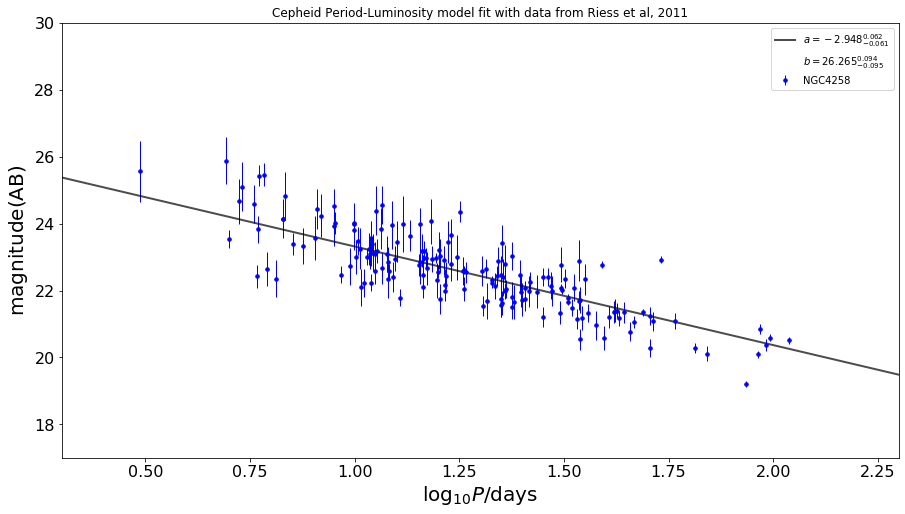

100%|███████████████████████████████████████████████| 2000/2000 [00:04<00:00, 452.13it/s]


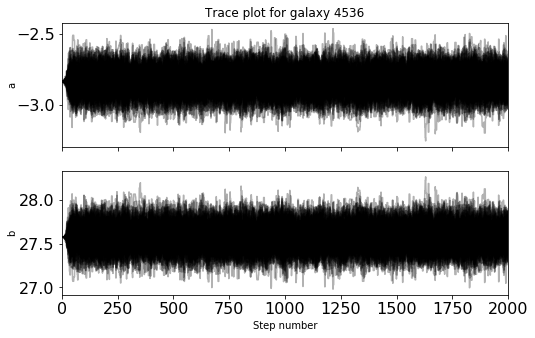

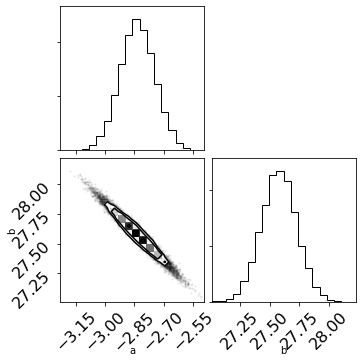

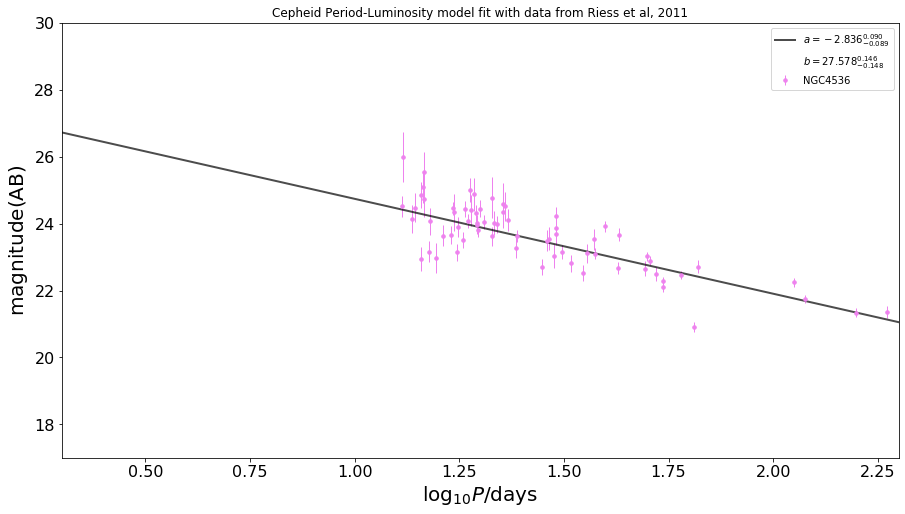

100%|███████████████████████████████████████████████| 2000/2000 [00:04<00:00, 478.04it/s]


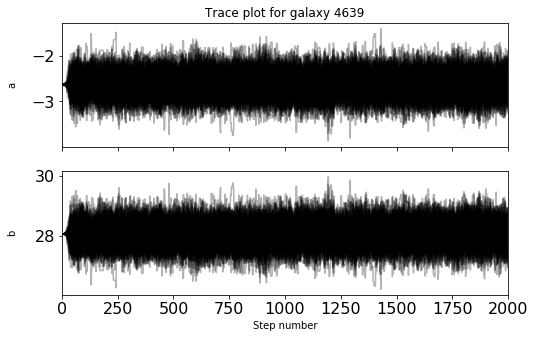

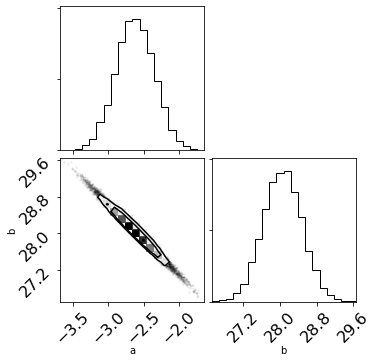

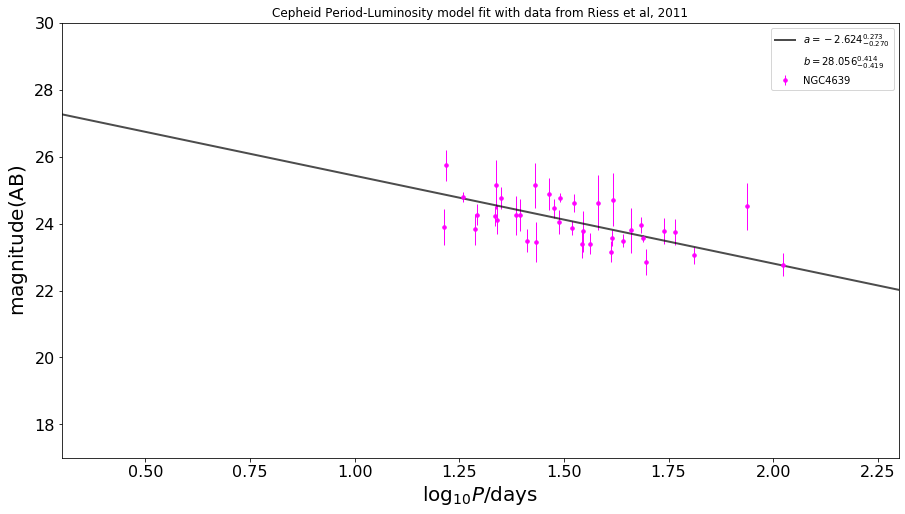

100%|███████████████████████████████████████████████| 2000/2000 [00:04<00:00, 459.94it/s]


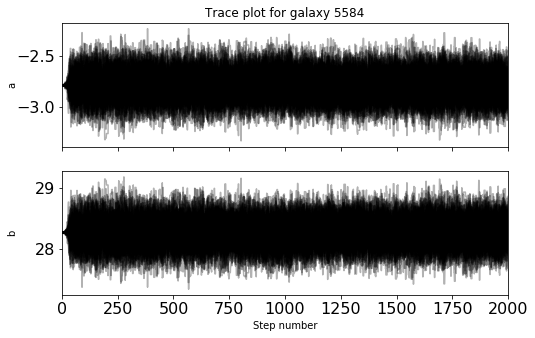

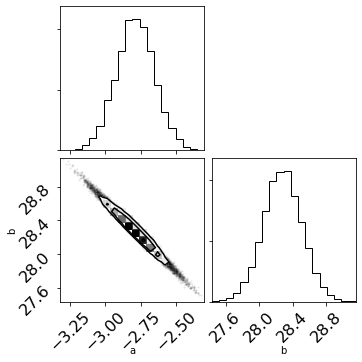

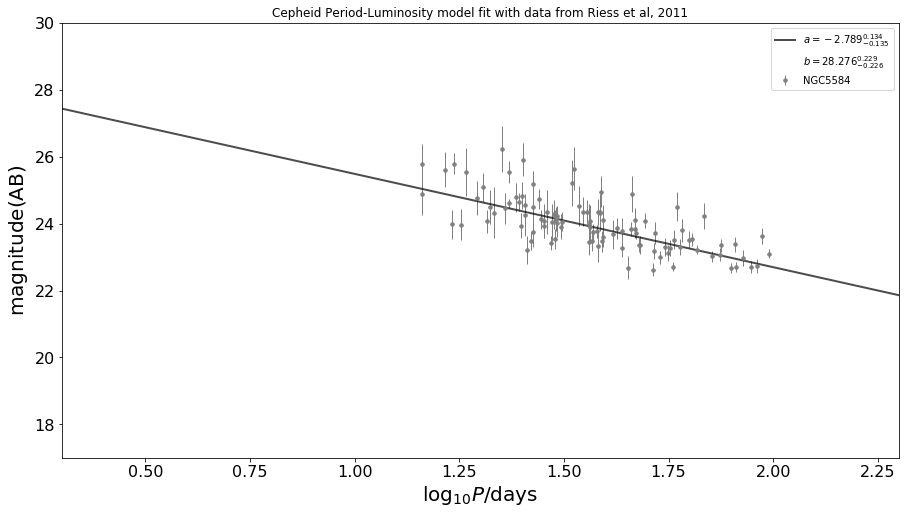

{'1309': 27.614751001112325, '3021': 29.060127099839022, '3370': 29.074199805959225, '3982': 28.140638568427967, '4038': 27.52195296042327, '4258': 26.264566681622924, '4536': 27.577864843733117, '4639': 28.056005495582184, '5584': 28.275936554779584}


In [22]:
import corner
import emcee
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from IPython.display import display, Math

#begin by setting up our priors that we talked about in Q2
def log_prior(theta):
    ai, bi = theta
    if -5.0 < ai < 0.0 and 24.0 < bi < 35.0:
        return 0.0
    return -np.inf

#incorporate this into a log probability
#note: our log likelihood is already predefined
def log_probability(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp - ceph.negative_log_likelihood(theta)

galaxy_intercepts = {}

#let's iterate thru each galaxy
for i, ID in enumerate(hosts):
    ceph.select(ID)

    #setting up our maximimum likelihood estimates
    initial = np.array([-2.5, 29.5])
    soln = minimize( ceph.negative_log_likelihood, initial)
    a_ml, b_ml = soln.x

    #now we start working on emcee
    nwalkers, ndim = 100, 2
    pos = soln.x + 1e-4 * np.random.randn(nwalkers, ndim)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)
    sampler.run_mcmc(pos, 2000, progress=True)
    samples = sampler.get_chain()
    
    #trace plots! 
    fig, axes = plt.subplots(2, figsize=(8, 5), sharex=True)
    labels = ['a', 'b']
    for i in range(ndim):
        ax = axes[i]
        ax.plot(samples[:, :, i], c='k', alpha=0.3)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)
    axes[-1].set_xlabel('Step number')
    axes[0].set_title(f'Trace plot for galaxy {ID}')
    plt.show()
    
    #determine the burn-in
    #tau is how long it takes until the walkers "forget" where they started
    tau = sampler.get_autocorr_time()
    #to be safe, we'll throw out a few multiples of tau, and thin by half of tau
    flat_samples = sampler.get_chain(discard=int(3*tau[0]), thin=int(0.5*tau[0]), flat=True)
    
    #corner plots!
    fig = corner.corner(flat_samples, labels=labels)
    plt.show()
    
    #figure out our model fits
    fits = []
    uncertainties = []
    legends = []
    for i in range(ndim):
        mcmc = np.percentile(flat_samples[:, i], [16, 50, 84]) #uncertainties based on the 16th, 50th, 84th percentiles
        uncertainty = np.diff(mcmc)
        fits.append(mcmc[1])
        uncertainties.append(uncertainty)
        
    #plot these fits on top of the data given using our fits and some prewritten functions
    ceph.plot(ID)
    a_label = f'${labels[0]} = {fits[0]:.3f}_{{-{uncertainties[0][0]:.3f}}}^{{{uncertainties[0][1]:.3f}}}$'
    b_label = f'${labels[1]} = {fits[1]:.3f}_{{-{uncertainties[1][0]:.3f}}}^{{{uncertainties[1][1]:.3f}}}$'
    ceph.overlay_straight_line_with(fits[0], fits[1], label=a_label)
    plt.plot(np.NaN, np.NaN, '-', color='none', label=b_label)
    plt.gca().invert_yaxis()
    plt.legend()
    plt.title(f'Cepheid Period-Luminosity model fit with data from Riess et al, 2011')
    plt.show()
    
    #add the y-intercepts to a dictionary for future reference
    galaxy_intercepts[f'{ID}'] = fits[1]
    
print(galaxy_intercepts)

In [24]:
#reiss table 3, column:"u0,i - u0,4258"
reiss_compared_to_4258 = {'4536':1.567, '4639':2.383, '3370':2.835, '3982':2.475, '3021':3.138, '1309':3.276, '5584':2.461, '4038':2.396}

#the same as above but for the intercepts i calculated
chris_compared_to_4258 = {galaxy: galaxy_intercepts[galaxy] - galaxy_intercepts['4258'] for galaxy in galaxy_intercepts}

#let's see how close i am
difference_reiss_chris = {galaxy: reiss_compared_to_4258[galaxy] - chris_compared_to_4258[galaxy] for galaxy in reiss_compared_to_4258}

print(f'{difference_reiss_chris}')

{'4536': 0.2537018378898066, '4639': 0.5915611860407397, '3370': 0.025366875663698885, '3982': 0.5989281131949569, '3021': 0.34243958178390166, '1309': 1.925815680510599, '5584': 0.4496301268433398, '4038': 1.1386137211996532}


Comparing my results to Reiss, I'm pretty close on some (3370 lookin' good!), while a bit off on others. Overall, I'm making the galaxies all look brighter than Reiss found them. I think my results are close enough to win a nobel prize.

# Q4.

## Riess et al. do a *simultaneous* fit to the Cepheids and SNe data (Table 3 of their paper). 

## I'm slightly less cruel, so you can take your intercepts $\mu_{0,i} - \mu_{0, 4258}$ and the re-express equation 4 using a substitution of equation 3.

## Write that expression down.

Eq 3

$$
m_{v,i}^0 = \left( \mu_{0,i} - \mu_{0,4258} \right) + m_{v,4258}^0
$$

Eq 4

$$
\log H_0 = \frac{\left( m_{v,4258}^0 -\mu_{0,4258} \right) + 5a_v + 25}{5}
$$

Combining these we get

$$
\log H_0 = \frac{\left( - \left( \mu_{0,i} - \mu_{0,4258} \right) -\mu_{0,4258} \right) + \left(m_{v,i}^0 + 5a_v \right) + 25}{5}
$$

# Q5

## Using the supernova data in Table 3 (enter it into whatever data structure you deem best) and the distance modulus to NGC 4258 from [Humphreys et al., 2013 ](https://ui.adsabs.harvard.edu/abs/2013ApJ...775...13H/abstract) and using the simple sample statistics you learned in Week 1, estimate the Hubble constant.

In [35]:
mvi5av = {'4536':15.147, '4639':16.040, '3370':16.545, '3982':15.953, '3021':16.699, '1309':16.768, '5584':16.274, '4038':15.901}
dist4258 = 7.60e6
mu0_4258 = 5*np.log10(dist4258)-5

H0_list = []

for galaxy in mvi5av:
    log_H0 = (-chris_compared_to_4258[galaxy] - mu0_4258 + mvi5av[galaxy] + 25)/5
    H0 = 10**log_H0
    H0_list.append(H0)
    
final_estimate = np.mean(H0_list)
final_error = np.std(H0_list)

print(f'H0 list: {H0_list}')
print(f'H0 = {round(final_estimate,2)} +/- {round(final_error,2)}')

H0 list: [76.90007711274392, 93.08906000962114, 73.49533653108675, 86.01457154117203, 79.40984056651084, 159.49590743842145, 93.69414082749196, 111.66296407916212]
H0 = 96.72 +/- 26.3


A few of our galaxies seem to be close to Reiss' best estimate of ~73.8, but we have a few galaxies that are really skewing our results at 159 and 111.